In [195]:
import torch
import pandas as pd
import numpy as np
import seaborn as sb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


## Reading Clean DataSet

In [196]:
merged_data = pd.read_csv('data/merged_data.csv')
ml_data = merged_data.drop(columns=['Set'])
ml_data = ml_data.dropna()
ml_data

,Year,Month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price_adjusted,average_storey
456621,2017,1,SEMBAWANG,4 ROOM,100.0,Model A,1999,81.333333,345907.470070,5.0
456622,2017,1,SEMBAWANG,4 ROOM,86.0,Model A2,2000,82.500000,314930.681705,2.0
456623,2017,1,QUEENSTOWN,5 ROOM,110.0,Improved,2006,88.916667,888001.266448,20.0
456624,2017,1,QUEENSTOWN,5 ROOM,111.0,Improved,2003,85.666667,826047.689719,20.0
456626,2017,1,QUEENSTOWN,4 ROOM,92.0,Model A,2013,95.250000,727954.526565,29.0
...,...,...,...,...,...,...,...,...,...,...
628402,2024,1,HOUGANG,4 ROOM,90.0,Model A,2003,78.416667,495000.000000,2.0
628403,2024,1,HOUGANG,4 ROOM,94.0,Model A,2019,94.916667,630000.000000,8.0
628404,2024,1,HOUGANG,4 ROOM,93.0,Model A,2018,93.833333,528000.000000,2.0
628405,2024,1,HOUGANG,4 ROOM,93.0,Model A,2019,94.666667,630000.000000,8.0


In [197]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143678 entries, 456621 to 628406
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Year                   143678 non-null  int64  
 1   Month                  143678 non-null  int64  
 2   town                   143678 non-null  object 
 3   flat_type              143678 non-null  object 
 4   floor_area_sqm         143678 non-null  float64
 5   flat_model             143678 non-null  object 
 6   lease_commence_date    143678 non-null  int64  
 7   remaining_lease        143678 non-null  float64
 8   resale_price_adjusted  143678 non-null  float64
 9   average_storey         143678 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 12.1+ MB


## Mapping object with dictionary

In [198]:
area_dict = {'QUEENSTOWN': 1, 'SERANGOON': 2, 'PASIR RIS': 3, 'TAMPINES': 4, 'MARINE PARADE': 5, 'KALLANG/WHAMPOA': 6, 'JURONG WEST': 7, 'WOODLANDS': 8, 'YISHUN': 9, 'TOA PAYOH': 10, 'BUKIT PANJANG': 11, 'BISHAN': 12, 'BUKIT BATOK': 13, 'BEDOK': 14, 'BUKIT MERAH': 15, 'ANG MO KIO': 16, 'HOUGANG': 17, 'JURONG EAST': 18, 'GEYLANG': 19, 'CHOA CHU KANG': 20, 'CLEMENTI': 21, 'CENTRAL AREA': 22, 'BUKIT TIMAH': 23, 'SENGKANG': 24, 'SEMBAWANG': 25, 'PUNGGOL': 26}
model_type_dict = {'Model A': 1, 'Standard': 2, 'Apartment': 3, 'Improved': 4, 'New Generation': 5, 'Simplified': 6, 'Terrace': 7, 'Adjoined flat': 8, 'Maisonette': 9, 'Multi Generation': 10, 'Premium Apartment': 11, 'Model A-Maisonette': 12, 'Improved-Maisonette': 13, 'Premium Maisonette': 14, '2-room': 15, 'Model A2': 16, 'DBSS': 17, 'Type S1': 18, 'Type S2': 19, 'Premium Apartment Loft': 20, '3Gen': 21}
flat_type_dict = {'5 ROOM': 1, 'EXECUTIVE': 2, '3 ROOM': 3, '4 ROOM': 4, '2 ROOM': 5, 'MULTI-GENERATION': 6, '1 ROOM': 7}


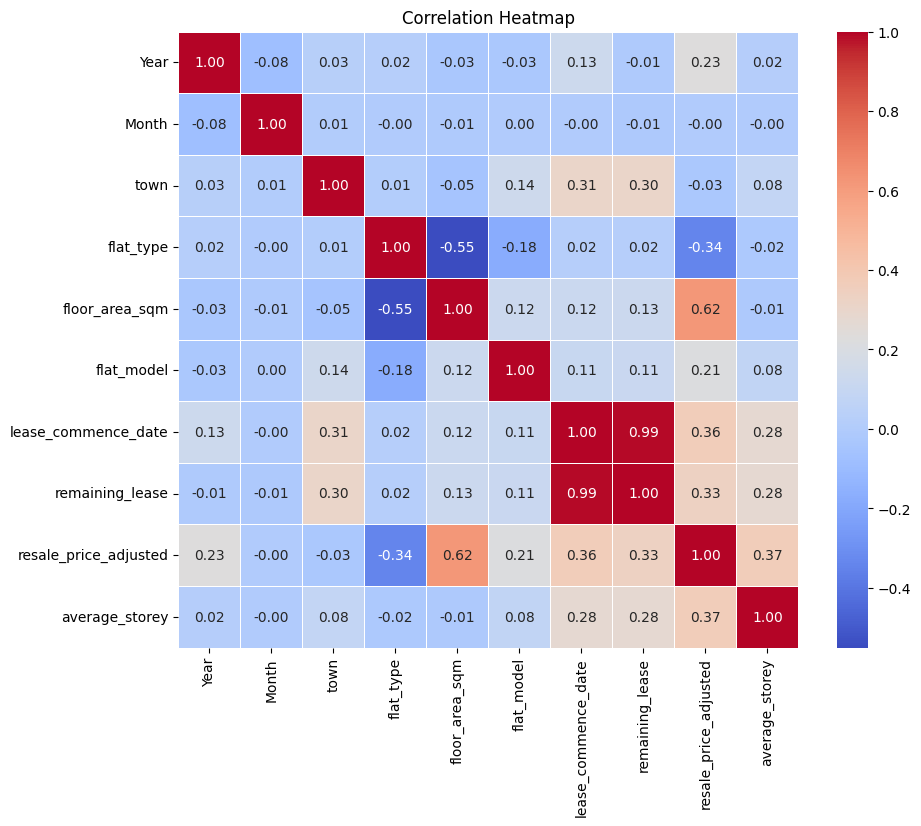

In [199]:
ml_data['town'] = ml_data['town'].map(area_dict)
ml_data['flat_type'] = ml_data['flat_type'].map(flat_type_dict)
ml_data['flat_model'] = ml_data['flat_model'].map(model_type_dict)

corr = ml_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [200]:
ml_data = ml_data.drop(columns=['Year','Month'])

In [201]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
rmse_scores = []

reg_alpha = 0.1
reg_lambda = 0.1

X, y = ml_data.drop(columns='resale_price_adjusted'), ml_data['resale_price_adjusted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', booster='gblinear', reg_alpha=reg_alpha, reg_lambda=reg_lambda)

xgb_reg.fit(X_train,y_train)


XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [202]:
from sklearn.metrics import r2_score 


# Make predictions on the test set
y_pred = xgb_reg.predict(X_test)

r2_score(y_test, y_pred)

0.5391656321681841

Mean Squared Error: 14152519720.037079


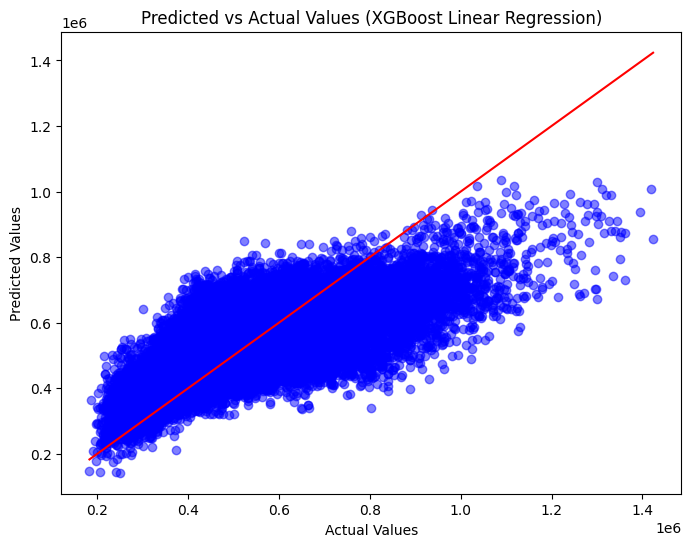

<Figure size 1000x600 with 0 Axes>

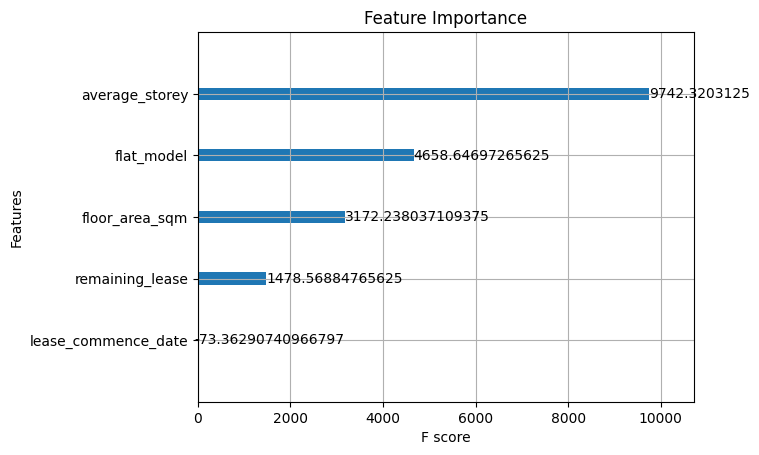

In [203]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (XGBoost Linear Regression)')
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_reg, max_num_features=5)  # Adjust max_num_features as needed
plt.title('Feature Importance')
plt.show()

In [204]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = abs(cross_val_score(xgb_reg, X_test, y_test, cv=kf, scoring='neg_mean_squared_error'))
mse_scores


array([1.41579521e+10, 1.40388014e+10, 1.36725543e+10, 1.38638058e+10,
       1.49623980e+10])